# Artificial Neural Network Forecasting

In [1]:
import os
import sys
import glob
import time
import pytz
import datetime as dt
import dateutil
from itertools import chain
from cycler import cycler
from io import StringIO


import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pvlib as pvlib
import seaborn as sns
import tensorflow as tf
import statistics

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
tf.random.set_seed(2)

ONE_DAY = dt.timedelta(days=1)

# Style of figures
plt.style.use('seaborn-poster')
# Size of figures
plt.rcParams['figure.figsize'] = 10, 7

In [2]:
COL_NAMES = [
    'date','SZA','SAA','DIRECT', 'DIFFUSE', 'GLOBAL', 'cGLOBAL', 
    'GLO_ARO1_J', 'GLO_ARO2_J', 'GLO_ARP_J', 'GLO_ARO1_J1', 'GLO_ARO2_J1', 'GLO_ARP_J1', 
    'mT2', 'T2_ARO1_J','T2_ARO2_J','T2_ARP_J','T2_ARO1_J1','T2_ARO2_J1','T2_ARP_J1', 
    'mRH','RH_ARO1_J','RH_ARO2_J','RH_ARP_J','RH_ARO1_J1','RH_ARO2_J1','RH_ARP_J1', 
]


def read_aa(files):

    for n, f in enumerate(files):
        tmp = pd.io.parsers.read_table(
            f,
            comment='#',
            sep=',',
            parse_dates=[0],
            date_parser=lambda s: dt.datetime.strptime(s, "%Y-%m-%d %H:%M:%S"),
            names=COL_NAMES,
            index_col='date',
            #na_values = ["-999", "-999.99", "-99.9"],
        )
        if n == 0:
            data = tmp
        else:
            data = pd.concat([data, tmp])

    return data

In [3]:
files = glob.glob('AROME_ARPEGE_SIRTA_Oct2015_Sep2019.txt')
data=read_aa(files)

In [4]:
data.columns

Index(['SZA', 'SAA', 'DIRECT', 'DIFFUSE', 'GLOBAL', 'cGLOBAL', 'GLO_ARO1_J',
       'GLO_ARO2_J', 'GLO_ARP_J', 'GLO_ARO1_J1', 'GLO_ARO2_J1', 'GLO_ARP_J1',
       'mT2', 'T2_ARO1_J', 'T2_ARO2_J', 'T2_ARP_J', 'T2_ARO1_J1', 'T2_ARO2_J1',
       'T2_ARP_J1', 'mRH', 'RH_ARO1_J', 'RH_ARO2_J', 'RH_ARP_J', 'RH_ARO1_J1',
       'RH_ARO2_J1', 'RH_ARP_J1'],
      dtype='object')

In [5]:
data   = data.loc[(data.mT2 > -20) & (data.mRH > 0) & (data.GLOBAL > 0) & (data.cGLOBAL > 0) & (data.GLO_ARP_J1 > 0) & (data.GLO_ARP_J > 0) & (data.GLO_ARO1_J1 > 0) & (data.GLO_ARO1_J > 0) & (data.GLO_ARO2_J1 > 0) & (data.GLO_ARO2_J > 0) & (data.SZA < 85)]
datans = data.loc[(data.index.year == 2016) & (data.mT2 > -20) & (data.mRH > 0) & (data.GLOBAL > 0) & (data.cGLOBAL > 0) & (data.GLO_ARP_J1 > 0) & (data.GLO_ARP_J > 0) & (data.GLO_ARO1_J1 > 0) & (data.GLO_ARO1_J > 0) & (data.GLO_ARO2_J1 > 0) & (data.GLO_ARO2_J > 0) & (data.SZA < 85)]
data = data.loc[data.index.year != 2016]

In [6]:
data['kt'] = data.GLOBAL / data.cGLOBAL

In [7]:
# data.kt=(data.kt-min(data.kt))/(max(data.kt)-min(data.kt))
# data.mT2=(data.mT2-min(data.mT2))/(max(data.mT2)-min(data.mT2))
# data.mRH=(data.mRH-min(data.mRH))/(max(data.mRH)-min(data.mRH))
# data.GLO_ARO1_J=(data.GLO_ARO1_J-min(data.GLO_ARO1_J))/(max(data.GLO_ARO1_J)-min(data.GLO_ARO1_J))
# data.GLO_ARO2_J=(data.GLO_ARO2_J-min(data.GLO_ARO2_J))/(max(data.GLO_ARO2_J)-min(data.GLO_ARO2_J))
# data.GLO_ARP_J=(data.GLO_ARP_J-min(data.GLO_ARP_J))/(max(data.GLO_ARP_J)-min(data.GLO_ARP_J))
# data.GLO_ARO1_J1=(data.GLO_ARO1_J1-min(data.GLO_ARO1_J1))/(max(data.GLO_ARO1_J1)-min(data.GLO_ARO1_J1))
# data.GLO_ARO2_J1=(data.GLO_ARO2_J1-min(data.GLO_ARO2_J1))/(max(data.GLO_ARO2_J1)-min(data.GLO_ARO2_J1))
# data.GLO_ARP_J1=(data.GLO_ARP_J1-min(data.GLO_ARP_J1))/(max(data.GLO_ARP_J1)-min(data.GLO_ARP_J1))
#data.GLOBAL=(data.GLOBAL-min(data.GLOBAL))/(max(data.GLOBAL)-min(data.GLOBAL))

# data = data.loc[(data.GLOBAL>0) & (data.kt>0) & (data.mT2>0) & (data.mRH>0) & (data.GLO_ARO1_J>0) & (data.GLO_ARO2_J>0) & (data.GLO_ARP_J>0) & (data.GLO_ARO1_J1>0) & (data.GLO_ARO2_J1>0) & (data.GLO_ARP_J1>0)] 
# data['mT2 * kt'] = data.mT2 * data.kt
# data['mRH * kt'] = data.mRH * data.kt 
# # data['var13'] = data.mRH * data.mT2
# # data['var14'] = data.mT2 * data.kt * data.mRH
# data['GLO_ARP_J1 * kt'] = data.GLO_ARP_J1 * data.kt
# data['GLO_ARP_J * kt'] = data.GLO_ARP_J * data.kt 
# data['GLO_ARO1_J1 * kt'] = data.GLO_ARO1_J1 * data.kt
# data['GLO_ARO1_J * kt'] = data.GLO_ARO1_J * data.kt 
# data['GLO_ARO2_J1 * kt'] = data.GLO_ARO2_J1 * data.kt
# data['GLO_ARO2_J * kt'] = data.GLO_ARO2_J * data.kt 
#X = data[['kt','mT2','mRH','GLO_ARO1_J','GLO_ARO2_J','GLO_ARP_J','GLO_ARO1_J1','GLO_ARO2_J1','GLO_ARP_J1']]
#Y = data[['GLOBAL']]

In [8]:
X = data[['SAA','SZA','GLO_ARO1_J','GLO_ARO2_J','GLO_ARP_J','GLO_ARO1_J1','GLO_ARO2_J1','GLO_ARP_J1']]
X

,SAA,SZA,GLO_ARO1_J,GLO_ARO2_J,GLO_ARP_J,GLO_ARO1_J1,GLO_ARO2_J1,GLO_ARP_J1
date,,,,,,,,
2015-10-17 07:00:00,-62.2,79.1,64.7,65.1,20.6,88.8,86.0,30.7
2015-10-17 08:00:00,-49.4,71.0,74.7,87.8,41.9,97.1,68.9,176.0
2015-10-17 09:00:00,-35.0,64.3,245.9,268.7,111.4,153.3,175.4,294.7
2015-10-17 10:00:00,-19.1,59.9,470.0,469.5,274.7,449.6,460.8,362.0
2015-10-17 11:00:00,-1.9,58.1,364.6,360.7,272.9,333.5,344.1,361.9
...,...,...,...,...,...,...,...,...
2019-09-21 12:00:00,15.2,49.1,634.8,633.7,630.1,638.8,637.9,632.1
2019-09-21 13:00:00,33.7,53.2,568.2,567.3,562.8,571.2,567.8,564.6
2019-09-21 14:00:00,49.9,59.8,459.0,458.6,451.1,382.6,381.1,451.5


In [9]:
Y = data[['GLOBAL']]
Y

,GLOBAL
date,
2015-10-17 07:00:00,26.1
2015-10-17 08:00:00,67.5
2015-10-17 09:00:00,188.8
2015-10-17 10:00:00,368.7
2015-10-17 11:00:00,293.3
...,...
2019-09-21 12:00:00,645.6
2019-09-21 13:00:00,582.5
2019-09-21 14:00:00,469.7


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [11]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError

In [12]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [13]:
# loss function
msle = MeanSquaredLogarithmicError()
#mse = MeanSquaredError()

model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]    
)
# train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=64,
    validation_split=0.2
)
print(model.summary())

Epoch 1/10
99/99 [==============================] - 3s 15ms/step - loss: 0.5263 - mean_squared_logarithmic_error: 0.5261 - val_loss: 0.1574 - val_mean_squared_logarithmic_error: 0.1573
Epoch 2/10
99/99 [==============================] - 1s 7ms/step - loss: 0.1965 - mean_squared_logarithmic_error: 0.1965 - val_loss: 0.1624 - val_mean_squared_logarithmic_error: 0.1624
Epoch 3/10
99/99 [==============================] - 1s 13ms/step - loss: 0.1859 - mean_squared_logarithmic_error: 0.1859 - val_loss: 0.1844 - val_mean_squared_logarithmic_error: 0.1844
Epoch 4/10
99/99 [==============================] - 1s 11ms/step - loss: 0.1883 - mean_squared_logarithmic_error: 0.1883 - val_loss: 0.1559 - val_mean_squared_logarithmic_error: 0.1558
Epoch 5/10
99/99 [==============================] - 1s 13ms/step - loss: 0.1856 - mean_squared_logarithmic_error: 0.1857 - val_loss: 0.1699 - val_mean_squared_logarithmic_error: 0.1699
Epoch 6/10
99/99 [==============================] - 1s 9ms/step - loss: 0.19

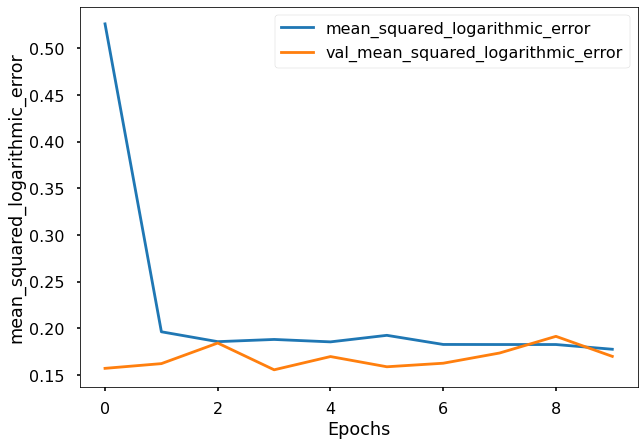

In [14]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')
#'mean_squared_error')
             #

                         GLOBAL
date                           
2019-07-27 05:00:00    0.401811
2019-08-01 10:00:00   82.192828
2019-02-16 14:00:00   83.137711
2019-08-30 17:00:00   61.773987
2018-10-10 10:00:00  118.253046
...                         ...
2017-08-13 08:00:00   13.315417
2018-05-04 14:00:00  163.619543
2017-03-17 11:00:00    2.182837
2018-07-19 08:00:00   85.191113
2017-05-23 16:00:00   49.856226

[1979 rows x 1 columns]
26.42194943040974


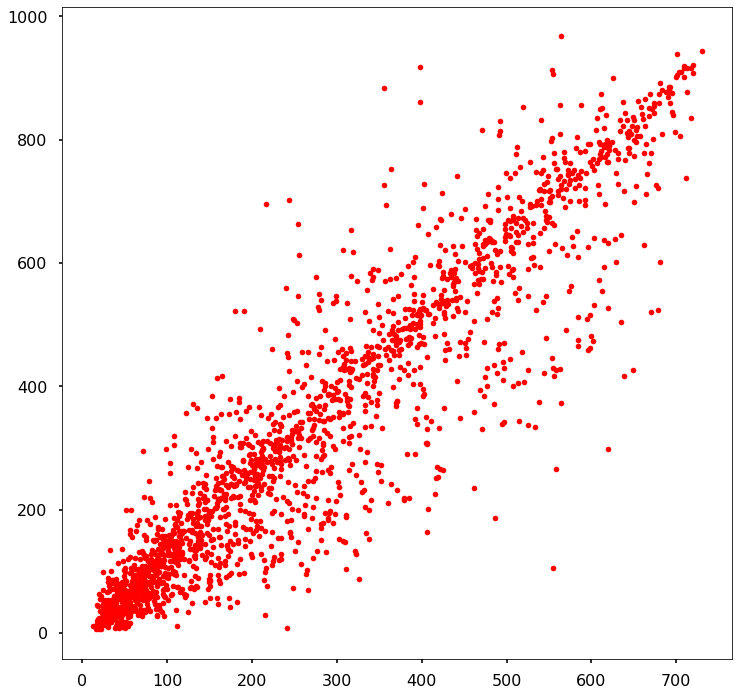

In [15]:
model.predict(X_test)
ax = plt.figure( figsize = (12,12) )
# plt.scatter(X_test,model.predict(X_test),color='blue',marker='.')
# plt.scatter(X_test,y_test,color='red',marker='.')
plt.plot(model.predict(X_test),y_test,color='red',linestyle='none',marker='.')
lathos = np.abs((model.predict(X_test) - y_test))#/y_test
print((lathos))
print(100 * np.average(lathos)/np.average(y_test))
# plt.plot(data.index,y_test,linestyle='none',marker='.')

In [16]:
import sklearn
from sklearn.metrics import r2_score
sklearn.metrics.r2_score(model.predict(X_test), y_test)

0.6474377791748963

In [17]:
# datans['kt'] = datans.GLOBAL / datans.cGLOBAL
# datans['var11'] = datans.mT2 * datans.kt
# datans['var12'] = datans.mRH * datans.kt 
# datans['var15'] = datans.GLO_ARP_J1 * datans.kt
# datans['var16'] = datans.GLO_ARP_J * datans.kt 
# datans['var17'] = datans.GLO_ARO1_J1 * datans.kt
# datans['var18'] = datans.GLO_ARO1_J * datans.kt 
# datans['var19'] = datans.GLO_ARO2_J1 * datans.kt
# datans['var20'] = datans.GLO_ARO2_J * datans.kt

Xns_test = datans[['SAA','SZA','GLO_ARO1_J','GLO_ARO2_J','GLO_ARP_J','GLO_ARO1_J1','GLO_ARO2_J1','GLO_ARP_J1']]
Yns_test = datans[['GLOBAL']]

GLOBAL    516.25957
dtype: float64
GLOBAL    0.015275
dtype: float64
28.253742385560184


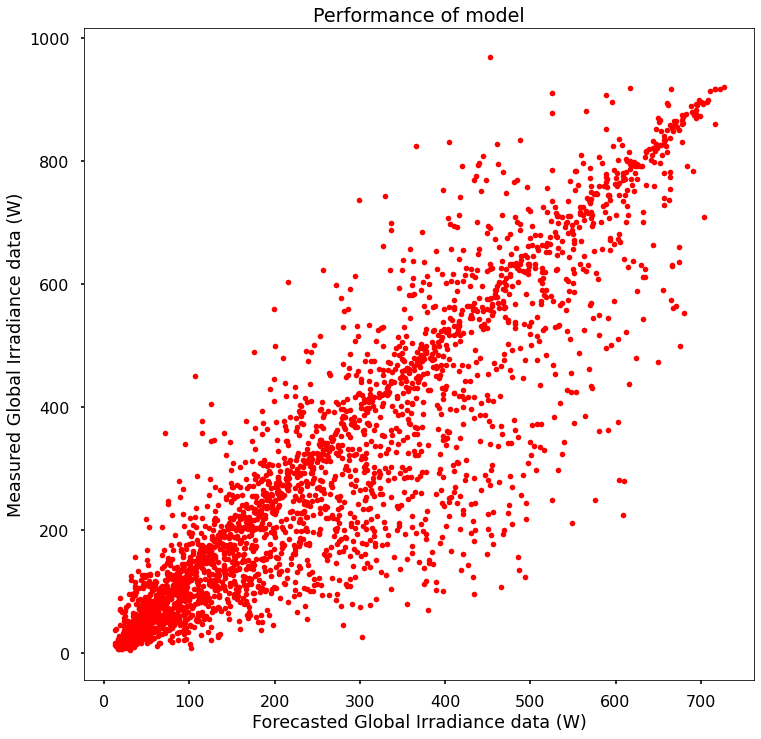

In [18]:
ax = plt.figure( figsize = (12,12) )
plt.plot(model.predict(Xns_test),Yns_test,color='red',linestyle='none',marker='.')
plt.xlabel('Forecasted Global Irradiance data (W)')
plt.ylabel('Measured Global Irradiance data (W)')
plt.title('Performance of model')
Yns_pred=model.predict(Xns_test)
lathosns = np.abs((Yns_pred - Yns_test))#/y_test
print(np.max(np.abs((model.predict(Xns_test) - Yns_test))))
print(np.min(np.abs((model.predict(Xns_test) - Yns_test))))
print(100 * np.average(lathosns)/np.average(Yns_test))
datans['GLOBALP'] = model.predict(Xns_test)

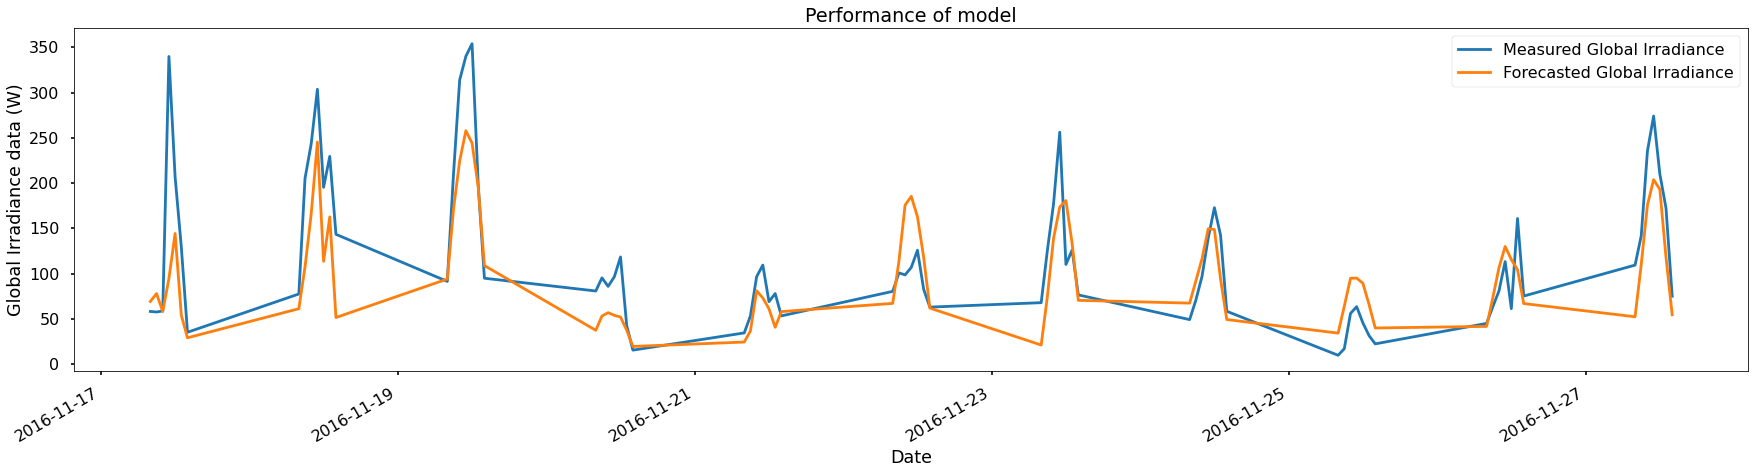

In [26]:
fig,ax = plt.subplots(figsize=(30,7))
datans['20161117':'20161127'][['GLOBAL','GLOBALP']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Global Irradiance data (W)')
plt.title('Performance of model')
plt.legend(['Measured Global Irradiance', 'Forecasted Global Irradiance'])

In [20]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# X_train = torch.from_numpy(X_train.to_numpy()).float()
# y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

# X_test = torch.from_numpy(X_test.to_numpy()).float()
# y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [21]:
# class Model(nn.Module):
#     def __init__(self, n_features):
#         super(Model, self).__init__()
#         self.lin1 = nn.Linear(n_features, 25)
#         self.lin2 = nn.Linear(25, 50)
#         self.lin3 = nn.Linear(50, 1)
        
#     def forward(self, x):
#         x = torch.tanh(self.lin1(x))
#         x = torch.tanh(self.lin2(x))
#         return torch.sigmoid(self.lin3(x))

# net =  Model(X_train.shape[1])
# print(net)

In [22]:
# import torch.optim as optim
# import time

# loss_criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.005)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# X_train = X_train.to(device)
# y_train = y_train.to(device)
# X_test = X_test.to(device)
# y_test = y_test.to(device)
# net = net.to(device)
# loss_criterion = loss_criterion.to(device)

In [23]:
# def calculate_accuracy(y_true, y_pred):
#   predicted = y_pred.ge(.5).view(-1)
#   return (y_true == predicted).sum().float() / len(y_true)

# for epoch in range(1000):
#     y_pred = net(X_train)
#     y_pred = torch.squeeze(y_pred)
#     train_loss = loss_criterion(y_pred, y_train)
    
#     if epoch % 10 == 0:
#       train_acc = calculate_accuracy(y_train, y_pred)
#       y_test_pred = net(X_test)
#       y_test_pred = torch.squeeze(y_test_pred)
#       test_loss = loss_criterion(y_test_pred, y_test)
#       test_acc = calculate_accuracy(y_test, y_test_pred)
#       print(
# f'''epoch {epoch}
# Train set - loss: {train_loss}, accuracy: {train_acc}
# Test  set - loss: {test_loss}, accuracy: {test_acc}
# ''')

#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()